# Copper Energy Demands
This journal documents the energy demands of mining, refining, drawing and recycling of copper for use inside the PV cell. Probably also applies to copper in wiring (not yet considered)

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8, 4)
cwd = os.getcwd() #grabs current working directory

### Mining Energy

In [2]:
cu_mining_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-copper-mining.csv",
                                     index_col='year')
cu_mining_raw.dropna(how='all')

,E_CuMining_kWhpkg,PrctFuel,Source,Notes
year,,,,
1975,15.947000,NaN,"Bravard, J. C., H. B. Flora, and Charles Porta...",mining and milling and flotation of 0.3% Cu or...
2001,1.319000,90.74%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."
2002,0.611000,43.18%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, underground mine, likely includes tra..."
2009,0.006000,NaN,"Bleiwas, Donald. 2011. “Estimates of Electrici...","Table 13, processed ore instead of tonne coppe..."
2010,11.110800,NaN,"Norgate, Terry, and Sharif Jahanshahi. 2011. “...","Cu Mining and mineral processing HYDRO, embodi..."
2011,18.055050,NaN,"Norgate, Terry, and Sharif Jahanshahi. 2011. “...","Cu Mining and mineral processing PYRO, emboied E"
2013,3.499902,NaN,"Elshkaki, Ayman, T. E. Graedel, Luca Ciacci, a...","range of 30-90 for ""primary production"", which..."
2014,2.244400,92.57%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."
2015,1.097200,43.54%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, underground mine, likely includes tra..."


Text(0, 0.5, 'kWh/kg')

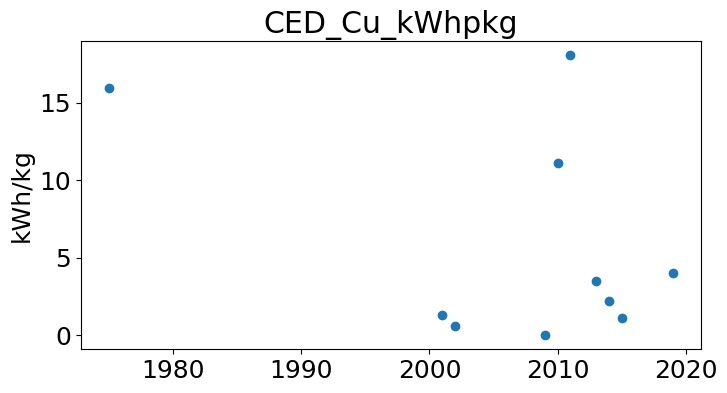

In [3]:
plt.scatter(cu_mining_raw.index, cu_mining_raw['E_CuMining_kWhpkg'], marker='o')
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

In [12]:
#drop ones that include more than just mining and concentration.
cu_mining_raw.loc[1975] = np.nan
cu_mining_raw.loc[2010] = np.nan
cu_mining_raw.loc[2011] = np.nan


Text(0, 0.5, 'kWh/kg')

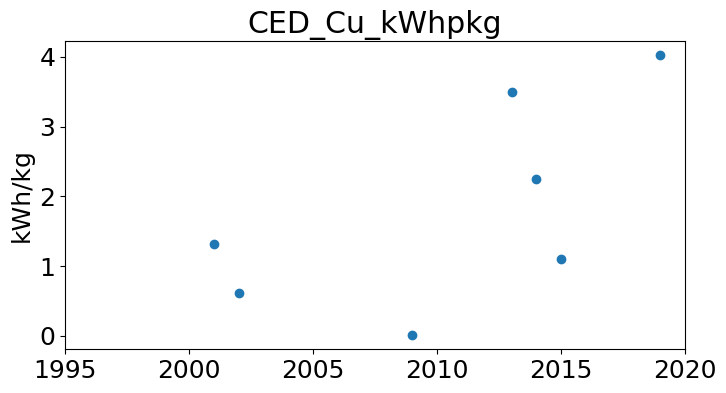

In [15]:
plt.scatter(cu_mining_raw.index, cu_mining_raw['E_CuMining_kWhpkg'], marker='o')
plt.xlim(1995,2020)
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

### CED

In [4]:
cu_CED_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-copper-CED.csv",
                                     index_col='year')
cu_CED_raw.dropna(how='all')

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,25.0000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","gross energy requirement cathodic copper, van ..."
1999,0.2940,NaN,"R. U. Ayres, L. W. Ayres, and I. Råde, The Lif...","Chilean Cu Smelters, average"
2000,9.1667,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, pyro, from Norgate and Rankin..."
2001,17.9170,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, hydro, from Norgate and Ranki..."
2003,16.6670,NaN,"R. U. Ayres, L. W. Ayres, and I. Råde, The Lif...","avg ore grade (>0.1% grade), OECD"
2005,14.9000,20.0,"Marsden, John O. “Energy Efficiency & Copper H...","Slide 33+35, 35% SX/EW 65% Concentrate, assume..."
2006,17.7770,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate, heap leaching and SX/EW p..."
2007,9.1660,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate of mfg, includes Smelting/..."
2008,16.8330,NaN,"Nuss, Philip, and Matthew J. Eckelman. 2014. “...","average of non-secondary, different mine sourc..."


Text(0, 0.5, 'kWh/kg')

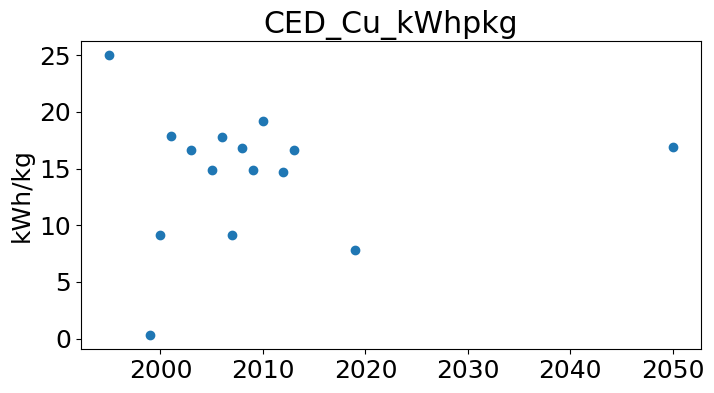

In [5]:
plt.scatter(cu_CED_raw.index, cu_CED_raw['CED_Cu_kWhpkg'], marker='o')
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

In [6]:
#drop the low outlier
cu_CED_raw.loc[1999] = np.nan
#drop the 2009 Nuss datapoint because it includes recycled content
cu_CED_raw.loc[2009] = np.nan
#drop 2012 EU survey, includes scrap content
cu_CED_raw.loc[2012] = np.nan

The remaining lower energy points are associated with the difference between Hydro and Pyro metallurgy. 

In [7]:
cu_CED_raw.loc[2000:2001,['Notes']]

,Notes
year,
2000,"embodied energy, pyro, from Norgate and Rankin..."
2001,"embodied energy, hydro, from Norgate and Ranki..."


In [8]:
cu_CED_raw.loc[2006:2007,['Notes']]

,Notes
year,
2006,"GER, cradle to gate, heap leaching and SX/EW p..."
2007,"GER, cradle to gate of mfg, includes Smelting/..."


In [9]:
#find pyro data
cu_CED_trim = cu_CED_raw.dropna(how='all')
cu_CED_trim_pyro = cu_CED_trim[cu_CED_trim['Notes'].str.contains('pyro')]
cu_CED_trim_pyro#.index

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
2000,9.1667,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, pyro, from Norgate and Rankin..."
2007,9.1660,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate of mfg, includes Smelting/..."
2010,19.1670,NaN,"Rötzer, Nadine, and Mario Schmidt. 2020. “Hist...","CED for Cu anodes (not wire), pyrometallurgy f..."
2050,16.9000,NaN,"Rötzer, Nadine, and Mario Schmidt. 2020. “Hist...","copper cathode, assumes 0.5% ore grade and 100..."


In [10]:
#find hydro data
cu_CED_trim_hydro = cu_CED_trim[cu_CED_trim['Notes'].str.contains('hydro')]
cu_CED_trim_hydro#.index

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
2001,17.917,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, hydro, from Norgate and Ranki..."
2005,14.900,20.0,"Marsden, John O. “Energy Efficiency & Copper H...","Slide 33+35, 35% SX/EW 65% Concentrate, assume..."


Text(0, 0.5, 'kWh/kg')

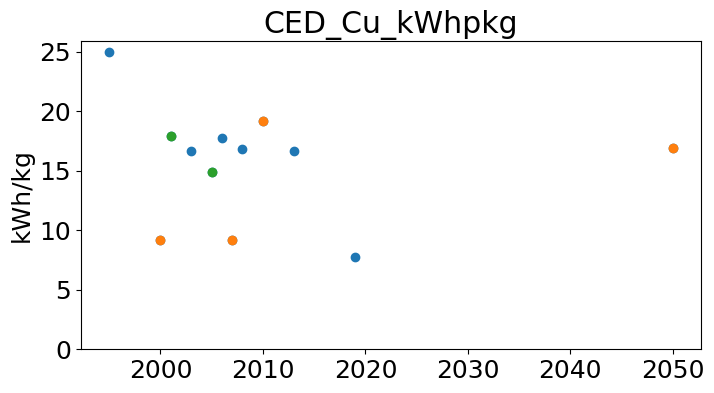

In [11]:
plt.scatter(cu_CED_raw.index, cu_CED_raw['CED_Cu_kWhpkg'], marker='o')
plt.scatter(cu_CED_trim_pyro.index, cu_CED_trim_pyro['CED_Cu_kWhpkg'], marker='o')
plt.scatter(cu_CED_trim_hydro.index, cu_CED_trim_hydro['CED_Cu_kWhpkg'], marker='o')

plt.ylim(0,)
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

Another way to go about the calculation of energy for primary Cu is to use the relationship between ore grade and energy demands. These appear regularly in literature, and history+projections of ore grade over time exist.